In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from robo_limb_ml.models.fk_lstm import FK_LSTM

In [2]:
df_data = pd.read_csv('../data/data.csv')

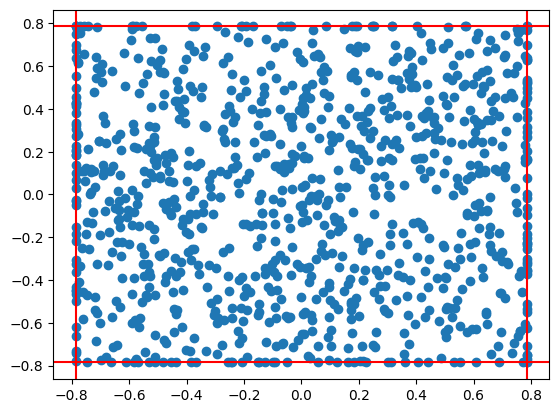

In [4]:
plt.scatter(df_data['angle1_p'][:1000], df_data['angle2_p'][:1000])
plt.axhline(y=-np.pi/4, color='r', linestyle='-')
plt.axhline(y=np.pi/4, color='r', linestyle='-')
plt.axvline(x=-np.pi/4, color='r', linestyle='-')
plt.axvline(x=np.pi/4, color='r', linestyle='-')

## Checking baseline MSE

In [59]:
random_guesses = np.random.uniform(-np.pi/4, np.pi/4, size=(df_data.shape[0], 2))
random_guesses_tensor = torch.from_numpy(random_guesses)
baseline_loss = nn.MSELoss()(random_guesses_tensor, torch.from_numpy(df_data[['angle1_p', 'angle2_p']].values))
print(f'Baseline loss: {baseline_loss.item()}')

Baseline loss: 0.4282946804198815


In [60]:
model_syn_data = FK_LSTM(input_size=11,
                        hidden_size=32,
                        num_layers=2,
                        device='cpu',
                        batch_first=True)
model_syn_data.load_state_dict(torch.load('../model_weights/syn_data_small_epochs'))
model_syn_data.eval()

model_full_data = FK_LSTM(input_size=11,
                        hidden_size=32,
                        num_layers=2,
                        device='cpu',
                        batch_first=True)
model_full_data.load_state_dict(torch.load('../model_weights/large_data_small_epochs'))
model_full_data.eval()

model_high_epoch_data = FK_LSTM(input_size=11,
                        hidden_size=32,
                        num_layers=2,
                        device='cpu',
                        batch_first=True)
model_high_epoch_data.load_state_dict(torch.load('../model_weights/small_data_large_epochs'))
model_high_epoch_data.eval()

model_small_epoch_data = FK_LSTM(input_size=11,
                        hidden_size=32,
                        num_layers=2,
                        device='cpu',
                        batch_first=True)
model_small_epoch_data.load_state_dict(torch.load('../model_weights/small_data_small_epochs'))
model_small_epoch_data.eval()

    

FK_LSTM(
  11, 32, num_layers=2, batch_first=True
  (dense_net): Linear(in_features=32, out_features=2, bias=True)
)

In [61]:
t = df_data['t'].values[:50]
pwm_values = df_data.iloc[:50, 8:].values

initial_input = torch.from_numpy(df_data.iloc[0, :-2].values).float()

syn_data_input = initial_input
full_data_input = initial_input
high_epoch_data_input = initial_input
small_epoch_data_input = initial_input

init_angle = df_data.iloc[0, 8:10].values
syn_data_preds = [init_angle]
full_data_preds = [init_angle]
high_epoch_data_preds = [init_angle]
small_epoch_data_preds = [init_angle]

for i in range(50):
    output_syn_data = model_syn_data(syn_data_input.unsqueeze(0).unsqueeze(0))
    output_full_data = model_full_data(full_data_input.unsqueeze(0).unsqueeze(0))
    output_high_epoch_data = model_high_epoch_data(high_epoch_data_input.unsqueeze(0).unsqueeze(0))
    output_small_epoch_data = model_small_epoch_data(small_epoch_data_input.unsqueeze(0).unsqueeze(0))

    output_syn_data = output_syn_data.squeeze().detach().numpy().T
    output_full_data = output_full_data.squeeze().detach().numpy().T
    output_high_epoch_data = output_high_epoch_data.squeeze().detach().numpy().T
    output_small_epoch_data = output_small_epoch_data.squeeze().detach().numpy().T

    syn_data_preds.append(output_syn_data)
    full_data_preds.append(output_full_data)
    high_epoch_data_preds.append(output_high_epoch_data)
    small_epoch_data_preds.append(output_small_epoch_data)

    syn_data_input = torch.cat([torch.from_numpy(pwm_values[i]).float(), torch.from_numpy(output_syn_data).float(), torch.tensor([t[i]]).float()])
    full_data_input = torch.cat([torch.from_numpy(pwm_values[i]).float(), torch.from_numpy(output_full_data).float(), torch.tensor([t[i]]).float()])
    high_epoch_data_input = torch.cat([torch.from_numpy(pwm_values[i]).float(), torch.from_numpy(output_high_epoch_data).float(), torch.tensor([t[i]]).float()])
    small_epoch_data_input = torch.cat([torch.from_numpy(pwm_values[i]).float(), torch.from_numpy(output_small_epoch_data).float(), torch.tensor([t[i]]).float()])

syn_data_preds = np.array(syn_data_preds)
full_data_preds = np.array(full_data_preds)
high_epoch_data_preds = np.array(high_epoch_data_preds)
small_epoch_data_preds = np.array(small_epoch_data_preds)

time = np.append(0, np.cumsum(t)/1000)


In [62]:
data_gnd_truth = df_data[['angle1_p', 'angle2_p']].values[:50]
data_gnd_truth = np.vstack((init_angle, data_gnd_truth))
# print(data_gnd_truth.shape)

In [63]:
output_full_data.shape

(2,)

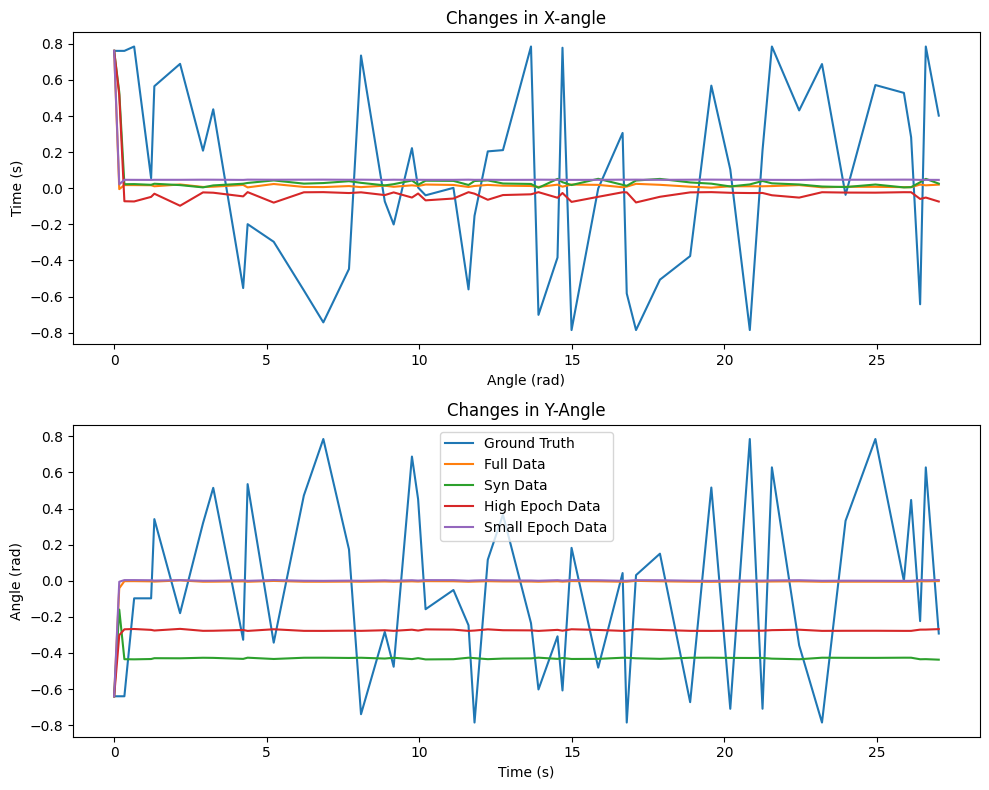

In [64]:

# Create a figure and a 2x1 grid of subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# First subplot emphasizing changes in X-axis
ax1.plot(time, data_gnd_truth[:, 0], label='Ground Truth')
ax1.plot(time, full_data_preds[:, 0], label='Full Data')
ax1.plot(time, syn_data_preds[:, 0], label='Syn Data')
ax1.plot(time, high_epoch_data_preds[:, 0], label='High Epoch Data')
ax1.plot(time, small_epoch_data_preds[:, 0], label='Small Epoch Data')
ax1.set_title('Changes in X-angle')
ax1.set_xlabel('Angle (rad)')
ax1.set_ylabel('Time (s)')

# Second subplot emphasizing changes in Y-axis by plotting Y vs. X
ax2.plot(time, data_gnd_truth[:, 1], label='Ground Truth')
ax2.plot(time, full_data_preds[:, 1], label='Full Data')
ax2.plot(time, syn_data_preds[:, 1], label='Syn Data')
ax2.plot(time, high_epoch_data_preds[:, 1], label='High Epoch Data')
ax2.plot(time, small_epoch_data_preds[:, 1], label='Small Epoch Data')
ax2.set_title('Changes in Y-Angle')
ax2.set_ylabel('Angle (rad)')
ax2.set_xlabel('Time (s)')

# Adjust layout
plt.tight_layout()
plt.legend()

# Show the plot
plt.show()

In [65]:
gnd_truth_inputs = torch.from_numpy(df_data.iloc[:50, :-2].values).float()
syn_data_preds = model_syn_data(gnd_truth_inputs.unsqueeze(0)).squeeze().detach().numpy()
full_data_preds = model_full_data(gnd_truth_inputs.unsqueeze(0)).squeeze().detach().numpy()
high_epoch_data_preds = model_high_epoch_data(gnd_truth_inputs.unsqueeze(0)).squeeze().detach().numpy()
small_epoch_data_preds = model_small_epoch_data(gnd_truth_inputs.unsqueeze(0)).squeeze().detach().numpy()


In [66]:
syn_data_preds = np.vstack((init_angle, syn_data_preds))
full_data_preds = np.vstack((init_angle, full_data_preds))
high_epoch_data_preds = np.vstack((init_angle, high_epoch_data_preds))
small_epoch_data_preds = np.vstack((init_angle, small_epoch_data_preds))

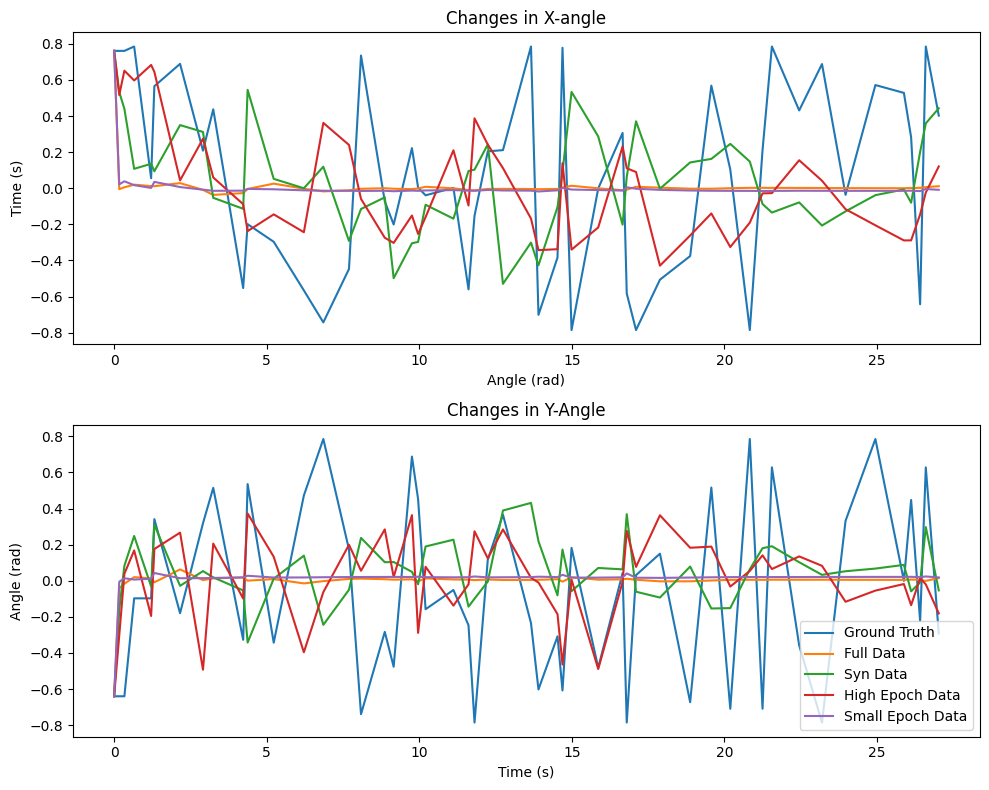

In [67]:
# Create a figure and a 2x1 grid of subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# First subplot emphasizing changes in X-axis
ax1.plot(time, data_gnd_truth[:, 0], label='Ground Truth')
ax1.plot(time, full_data_preds[:, 0], label='Full Data')
ax1.plot(time, syn_data_preds[:, 0], label='Syn Data')
ax1.plot(time, high_epoch_data_preds[:, 0], label='High Epoch Data')
ax1.plot(time, small_epoch_data_preds[:, 0], label='Small Epoch Data')
ax1.set_title('Changes in X-angle')
ax1.set_xlabel('Angle (rad)')
ax1.set_ylabel('Time (s)')

# Second subplot emphasizing changes in Y-axis by plotting Y vs. X
ax2.plot(time, data_gnd_truth[:, 1], label='Ground Truth')
ax2.plot(time, full_data_preds[:, 1], label='Full Data')
ax2.plot(time, syn_data_preds[:, 1], label='Syn Data')
ax2.plot(time, high_epoch_data_preds[:, 1], label='High Epoch Data')
ax2.plot(time, small_epoch_data_preds[:, 1], label='Small Epoch Data')
ax2.set_title('Changes in Y-Angle')
ax2.set_ylabel('Angle (rad)')
ax2.set_xlabel('Time (s)')

plt.tight_layout()
plt.legend()

In [23]:
import wandb
import numpy as np

In [31]:
api = wandb.Api()

runs = api.runs(path="gsue/RobLimbFK", filters={"display_name": {"$regex": ".*t_test.*"}})

syn_data_val_losses = []
full_data_val_losses = []
small_data_val_losses = []

syn_data_train_losses = []
full_data_train_losses = []
small_data_train_losses = []

c = 0
for run in runs:
    if 'syn_data' in run.display_name:
        syn_data_val_losses.append(run.summary['val_loss'])
        syn_data_train_losses.append(run.summary['Loss_epoch_per_batch'])
        c += 1
        print(run.name)

np.array(syn_data_val_losses).std(), np.array(syn_data_train_losses).std()

LSTM_b2048_e200_s131072_t_test_syn_data_small_epochs_40
LSTM_b2048_e200_s131072_t_test_syn_data_small_epochs_39
LSTM_b2048_e200_s131072_t_test_syn_data_small_epochs_38
LSTM_b2048_e200_s131072_t_test_syn_data_small_epochs_37
LSTM_b2048_e200_s131072_t_test_syn_data_small_epochs_36
LSTM_b2048_e200_s131072_t_test_syn_data_small_epochs_35
LSTM_b2048_e200_s131072_t_test_syn_data_small_epochs_34
LSTM_b2048_e200_s131072_t_test_syn_data_small_epochs_33
LSTM_b2048_e200_s131072_t_test_syn_data_small_epochs_32
LSTM_b2048_e200_s131072_t_test_syn_data_small_epochs_31
LSTM_b2048_e200_s131072_t_test_syn_data_small_epochs_30
LSTM_b2048_e200_s131072_t_test_syn_data_small_epochs_29
LSTM_b2048_e200_s131072_t_test_syn_data_small_epochs_28
LSTM_b2048_e200_s131072_t_test_syn_data_small_epochs_27
LSTM_b2048_e200_s131072_t_test_syn_data_small_epochs_26
LSTM_b2048_e200_s131072_t_test_syn_data_small_epochs_25
LSTM_b2048_e200_s131072_t_test_syn_data_small_epochs_24
LSTM_b2048_e200_s131072_t_test_syn_data_small_ep

(0.0, 0.0)

In [30]:
c

40